# Sarcasm Dectector

Adopted from [here](https://github.com/dylandrover/keras_tutorial/tree/master/keras_tutorial)

The problem is the following: detect whether the paragraph contains irony or not having only sentiments of sentences constitute this paragraph.

Sarcasm is defined as a paragraph consisting of sentences that have mixed emotions.

Each sentence is represented with an integer number from -2 to 2 denoting the sentiment:
* -2 is Very Negative
* -1 is Negative
* 0 is Neutral
* 1 is Positive
* 2 is Very Positive

Thus one paragraph (or sequence of sentences) is something like:
    
    1 -1 -1 -1 1 -1 -1 -1 -1 -1 2 -1 -1 1 1

And this is our one training example. For each example we should assign one of two labels:
* Ironic (ironic.txt)
* Regular (regular.txt)

Dataset was obtained in the following way:
* A corpus was found with sarcastic and regular reviews from https://amazon.com.
* Using the [Stanford Sentiment Analysis Recursive Network](http://stanfordnlp.github.io/CoreNLP/sentiment.html) (part of Stanford's CoreNLP toolkit) each sentence was determined to be Very Negative, Negative, Neutral, Positive or Very Positive. 
* From this, each paragraph's sentences were coded into a vector of numbers with Very Negative as -2, Negative as -1, Neutral as 0, Positive as +1 and Very Positive as +2. 
* The final vector is one training/testing sample. 

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn import metrics

from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, LSTM, Masking, Input
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


Set style

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["figure.figsize"] = (10, 8)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Random seed is put here just for the sake of reproducibility

In [3]:
np.random.seed(41)

# Data

All the data are stored in two filed $-$ one for ironic utterances and other for regular. Uterrance is no more than a sequence of integers. Sequences can vary in length depending on number of sentences in paragraph.

In [4]:
max_len = 0
samples = 0
ironic_num = 0
regular_num = 0
data = []

Read data line by line

In [5]:
ironic_file  = open('ironic.txt', 'r')
regular_file = open('regular.txt', 'r')

while True:
    curr_line = ironic_file.readline()
    if not curr_line:
        break
    curr_line = list(map(int, curr_line.split(' ')))
    data.append(curr_line)
ironic_num = len(data)
        
while True:
    curr_line = regular_file.readline()
    if not curr_line:
        break
    curr_line = list(map(int, curr_line.split(' ')))
    data.append(curr_line)
regular_num = len(data) - ironic_num

samples = len(data)
max_len = np.max(list(map(lambda x: len(x), data)))

ironic_file.close()
regular_file.close()

Here how one training sample looks like

In [6]:
print(data[0])

[1, 1, -2, -1, 1, 0, -1, -1, -1, 2, -1, 0, -1, -1, -1, 1, 1, 0, -1, -1, -1, -2, 1]


For now enumeration is from -2 to 2. Let's shift this $[-2; 2]$ range into $[1; 5]$.

The reason is that we're going to pad all the sequences with $0$ to have them with equal lengths (that's why we need $\text{max_len}$). Actually it is the constraint of the Keras (and any other deep learning library which works with tensors). Keras requires to have all inputs to be fed as one tensor. And to form a tensor all dimensions should have the same number of components. Thus all the sequences should be of the same length.

In our case $0$ will mean *no data*.

With LSTM's (but not with convolutions for now) Keras provides nice and easy way to overcome this padding. One can use *masked* input which means that all the zeros in the input sequences will be treated as empty places and predictions at these places won't be taken in account during the loss computation.

In [7]:
data = list(map(lambda x: x + [-3] * (max_len - len(x)), data))

In [8]:
data = np.array(data) + 3

Now the one input sample is

In [9]:
print(data[0])

[4 4 1 2 4 3 2 2 2 5 2 3 2 2 2 4 4 3 2 2 2 1 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Little reshaping to be consistent with Keras input format. Input tensor should have 3 dimensions:
1. Samples
2. Timesteps
3. Features

We have only one feauture at a time thus third dimension in our case will be "fake" dimension.

In [10]:
X = np.atleast_3d(data)

y = np.zeros(samples, dtype=np.int)
y[:ironic_num] = 1

Final format of input:

In [11]:
print("Label:", y[0])
print("Object:", X[0])

Label: 1
Object: [[4]
 [4]
 [1]
 [2]
 [4]
 [3]
 [2]
 [2]
 [2]
 [5]
 [2]
 [3]
 [2]
 [2]
 [2]
 [4]
 [4]
 [3]
 [2]
 [2]
 [2]
 [1]
 [4]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


Split into train and test set. Notice that we use one random state throughout the whole notebook to be consistent and to have an ability to compare results

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

Let's also notice one peculiarity of the data: classes are highly unbalanced

In [13]:
print("Irony:", np.sum(y==1))
print("Regular:", np.sum(y==0))

Irony: 429
Regular: 808


#  Convolutional Neural Network

Let's define a function that creates very basic CNN model. It contains only one convolutional, one pooling and few dense layers

In [14]:
def build_cnn_model():
    inp = Input(shape=(max_len, 1))

    layer = Convolution1D(filters=75, kernel_size=3, activation='relu')(inp)
    layer = MaxPooling1D(pool_size=4)(layer)

    layer = Flatten()(layer)
    layer = Dense(100, activation='relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(30, activation='relu')(layer)
    layer = Dropout(0.5)(layer)
    out = Dense(1, activation='sigmoid')(layer)

    model = Model(inputs=[inp], outputs=[out])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

Build model

In [15]:
model = build_cnn_model()

See what model is

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 67, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 65, 75)            300       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 75)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               120100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
__________

Visualize architecture

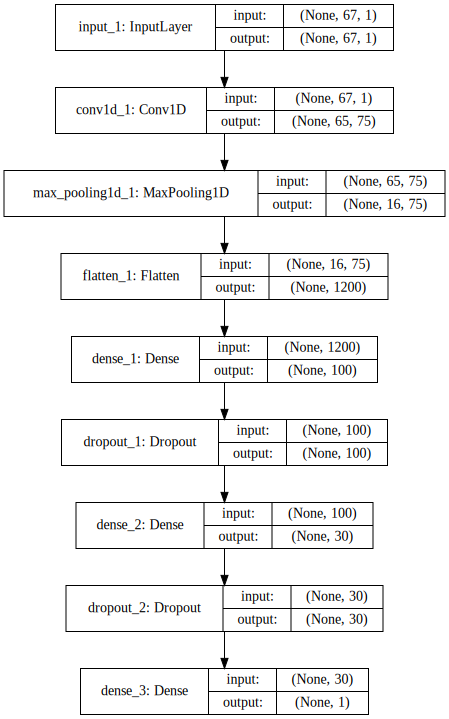

In [17]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Training CNN

We have unbalanced problem. The simplest tweak to deal with it is to reweight classes. It means that the error on small class will have bigger impact on the final objective. It is done by means of introducing "importance" coefficients per each sample in objective function.

In this particular case we decided to take the following class weigths:
$$
c_i \sim \frac{1}{\sqrt{N_i}}
$$
For two class problem and after normalizing (such that weights sum to $1$):
$$
c_0 = \frac{1/\sqrt{N_0}}{1/\sqrt{N_0} + 1/\sqrt{N_1}} = \frac{\sqrt{N_1}}{\sqrt{N_0} + \sqrt{N_1}}\\
c_1 = \frac{\sqrt{N_0}}{\sqrt{N_0} + \sqrt{N_1}}
$$

In [18]:
hist = model.fit(X_train, y_train, 
                 validation_data=(X_test, y_test), 
                 batch_size=25, epochs=50, verbose=0, 
                 class_weight={0: np.sqrt(ironic_num) * 1. / (np.sqrt(ironic_num) + np.sqrt(regular_num)), 
                               1: np.sqrt(regular_num) * 1. / (np.sqrt(ironic_num) + np.sqrt(regular_num))})

Training history and loss evolution

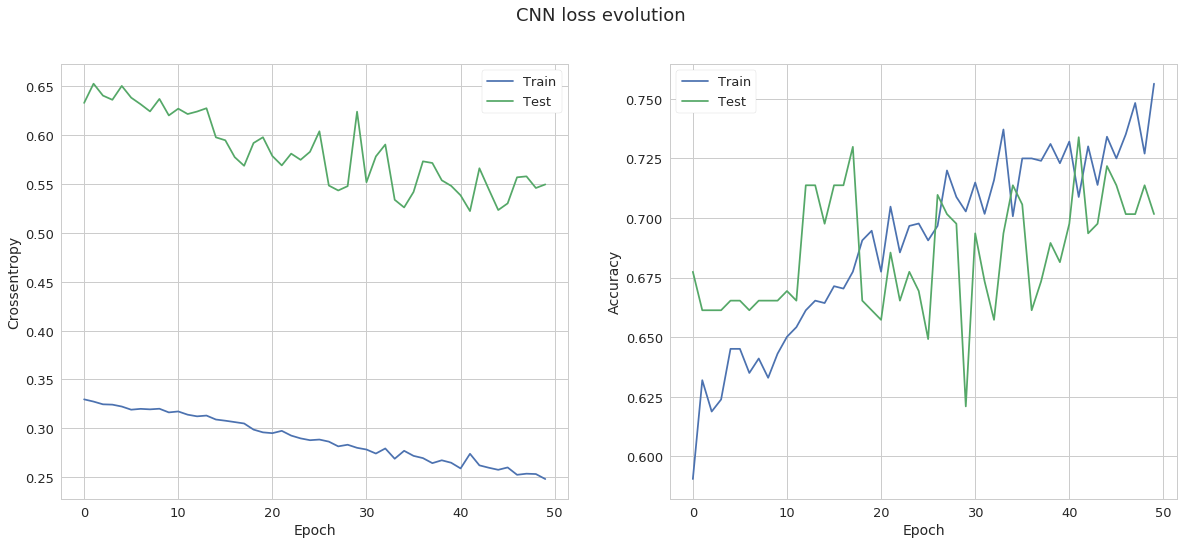

In [19]:
plt.figure(figsize=(20, 8))
plt.suptitle("CNN loss evolution", fontsize=18)

plt.subplot(121)
plt.plot(hist.history["loss"], label="Train")
plt.plot(hist.history["val_loss"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Crossentropy", fontsize=14)

plt.subplot(122)
plt.plot(hist.history["acc"], label="Train")
plt.plot(hist.history["val_acc"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14);

## Evaluation CNN

Do a prediction for both train and test

In [20]:
preds_train = model.predict(X_train, verbose=0)
preds_test = model.predict(X_test, verbose=0)

preds_train = (preds_train > 0.5).astype(np.int)
preds_test = (preds_test > 0.5).astype(np.int)

Accuracy

In [21]:
print("Train accuracy:\t", np.round(metrics.accuracy_score(y_train, preds_train), 3))
print("Test accuracy:\t", np.round(metrics.accuracy_score(y_test, preds_test), 3))

Train accuracy:	 0.769
Test accuracy:	 0.702


Confusion matrix

In [22]:
cm_train = metrics.confusion_matrix(y_train, preds_train).astype(np.float32)
cm_train /= cm_train.sum(axis=1)[:, np.newaxis]

cm_test = metrics.confusion_matrix(y_test, preds_test).astype(np.float32)
cm_test /= cm_test.sum(axis=1)[:, np.newaxis]

In [23]:
class_labels = ["Regular", "Irony"]

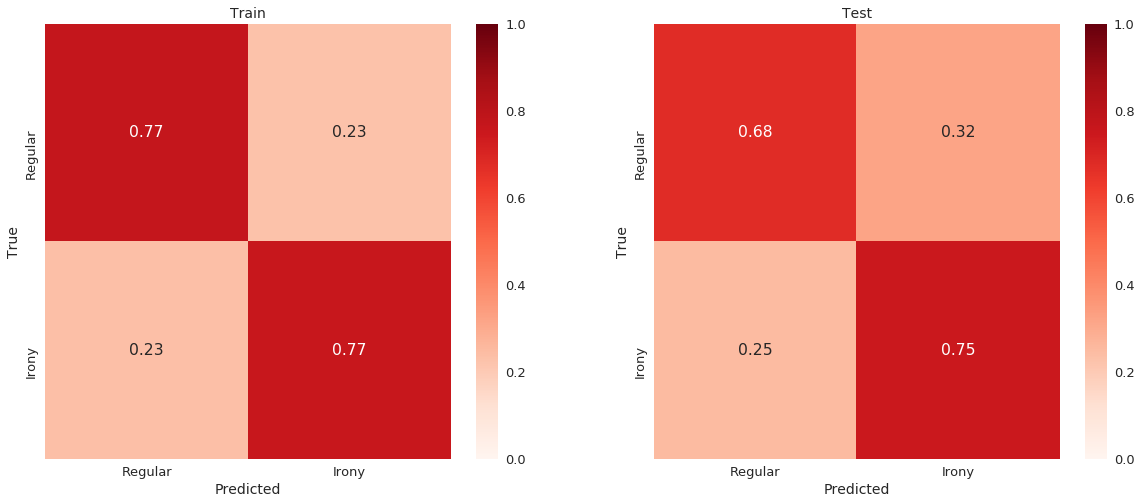

In [24]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
g = sns.heatmap(cm_train, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Train", fontsize=14)

plt.subplot(122)
g = sns.heatmap(cm_test, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test", fontsize=14);

In [25]:
print(metrics.classification_report(y_test, preds_test))

             precision    recall  f1-score   support

          0       0.85      0.68      0.75       168
          1       0.53      0.75      0.62        80

avg / total       0.75      0.70      0.71       248



## Cross-Validation CNN

Instead of splitting into train and test set once, we can split all data into $N$ blocks and use one of them as test set and others as a train consequently. From the statistical point of view such an estimation of the generalization ability is more accurate and less biased.

In [28]:
skf = StratifiedKFold(y, n_folds=5, shuffle=True)

accs_train = np.zeros(skf.n_folds)
cms_train = np.zeros((skf.n_folds, 2, 2))
accs_test = np.zeros(skf.n_folds)
cms_test = np.zeros((skf.n_folds, 2, 2))

index = 0

for train_index, test_index in skf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = build_cnn_model()

    hist = model.fit(X_train, y_train, 
                     validation_data=(X_test, y_test), 
                     batch_size=25, epochs=50, verbose=0, 
                     class_weight={0: np.sqrt(ironic_num) * 1. / (np.sqrt(ironic_num) + np.sqrt(regular_num)), 
                                   1: np.sqrt(regular_num) * 1. / (np.sqrt(ironic_num) + np.sqrt(regular_num))})

    preds_train = model.predict(X_train, verbose=0)
    preds_test = model.predict(X_test, verbose=0)
    preds_train = (preds_train > 0.5).astype(np.int)
    preds_test = (preds_test > 0.5).astype(np.int)
    
    accs_train[index] = metrics.accuracy_score(y_train, preds_train)
    accs_test[index] = metrics.accuracy_score(y_test, preds_test)
    
    cms_train[index] = metrics.confusion_matrix(y_train, preds_train)
    cms_train[index] /= cms_train[index].sum(axis=1)[:, np.newaxis]
    cms_test[index] = metrics.confusion_matrix(y_test, preds_test)
    cms_test[index] /= cms_test[index].sum(axis=1)[:, np.newaxis]
    
    index += 1
    print("Fold {:d} is ready".format(index))

Fold 1 is ready
Fold 2 is ready
Fold 3 is ready
Fold 4 is ready
Fold 5 is ready


In [29]:
print("CV Train accuracy:\t", np.round(np.mean(accs_train), 3))
print("CV Test accuracy:\t", np.round(np.mean(accs_test), 3))

CV Train accuracy:	 0.776
CV Test accuracy:	 0.697


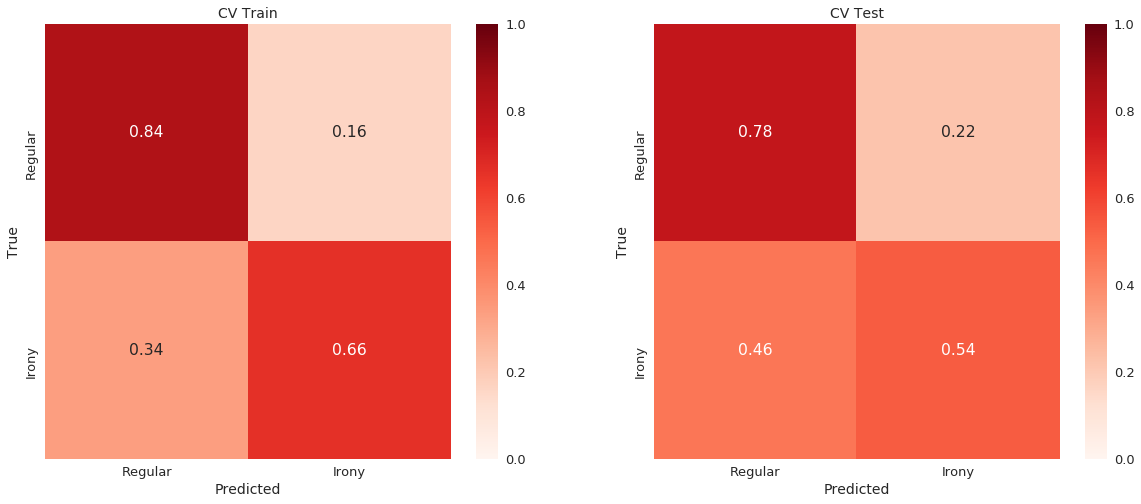

In [32]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
g = sns.heatmap(np.mean(cms_train, axis=0), vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("CV Train", fontsize=14)

plt.subplot(122)
g = sns.heatmap(np.mean(cms_test, axis=0), vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("CV Test", fontsize=14);

# Recurrent Neural Network

Here is a function to create simple LSTM model.

* **Masking** layer here allows to ignore all the zeros in the input (thing discussed in data section). All the places that has zeros at the input won't be taken into account during computation of error. This is very efficient mechanism to work with sequences of different lengths.

* Next there are two stacked **LSTM** layers. First one returns sequences. It means that for each input timestep there will be timestep in the output. In other words, first LSTM layer works in Sequence-2-Sequence mode. Second LSTM layer returns only the last output. One can think of it as a creation of special embedding that accumulates information across time dimension.

* Usual Dense classification layers

In [33]:
def build_rnn_model():
    inp = Input(shape=(max_len, 1))
    layer = Masking(mask_value=0)(inp)
    
    layer = LSTM(64, return_sequences=True)(layer)
    layer = LSTM(64, return_sequences=False)(layer)

    layer = Dense(100, activation='relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(30, activation='relu')(layer)
    layer = Dropout(0.5)(layer)
    out = Dense(1, activation='sigmoid')(layer)

    model = Model(inputs=[inp], outputs=[out])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

Build model

In [34]:
model = build_rnn_model()

See what model is

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 67, 1)             0         
_________________________________________________________________
masking_1 (Masking)          (None, 67, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 67, 64)            16896     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_25 (Dense)             (None, 100)               6500      
_________________________________________________________________
dropout_17 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 30)                3030      
__________

Visualize the architecture

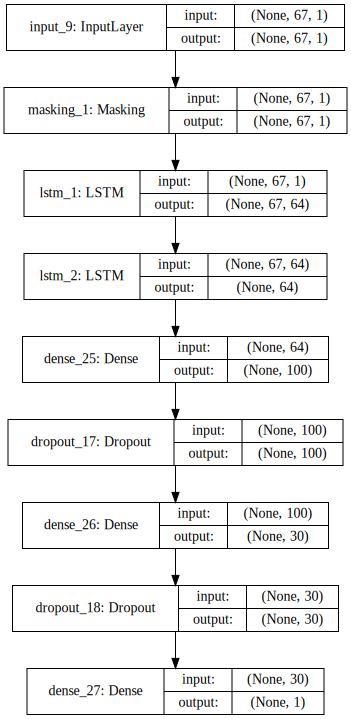

In [36]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Training RNN

Due to unbalanced classes in our problem we use the same reweighting technique as we did in CNN.

In [37]:
hist = model.fit(X_train, y_train, 
                 validation_data=(X_test, y_test), 
                 batch_size=25, epochs=20, verbose=1, 
                 class_weight={0: np.sqrt(ironic_num) * 1. / (np.sqrt(ironic_num) + np.sqrt(regular_num)), 
                               1: np.sqrt(regular_num) * 1. / (np.sqrt(ironic_num) + np.sqrt(regular_num))})

Train on 991 samples, validate on 246 samples
Epoch 1/20
991/991 [==============================] - 11s - loss: 0.3272 - acc: 0.6246 - val_loss: 0.6589 - val_acc: 0.6545
Epoch 2/20
991/991 [==============================] - 11s - loss: 0.3235 - acc: 0.6458 - val_loss: 0.6484 - val_acc: 0.6545
Epoch 3/20
991/991 [==============================] - 11s - loss: 0.3197 - acc: 0.6519 - val_loss: 0.6441 - val_acc: 0.6545
Epoch 4/20
991/991 [==============================] - 11s - loss: 0.3124 - acc: 0.6509 - val_loss: 0.6059 - val_acc: 0.6545
Epoch 5/20
991/991 [==============================] - 11s - loss: 0.3005 - acc: 0.6650 - val_loss: 0.5799 - val_acc: 0.6870
Epoch 6/20
991/991 [==============================] - 10s - loss: 0.2950 - acc: 0.6892 - val_loss: 0.5764 - val_acc: 0.6870
Epoch 7/20
991/991 [==============================] - 10s - loss: 0.3040 - acc: 0.6428 - val_loss: 0.5840 - val_acc: 0.6911
Epoch 8/20
991/991 [==============================] - 10s - loss: 0.2909 - acc: 0.6811

Training history

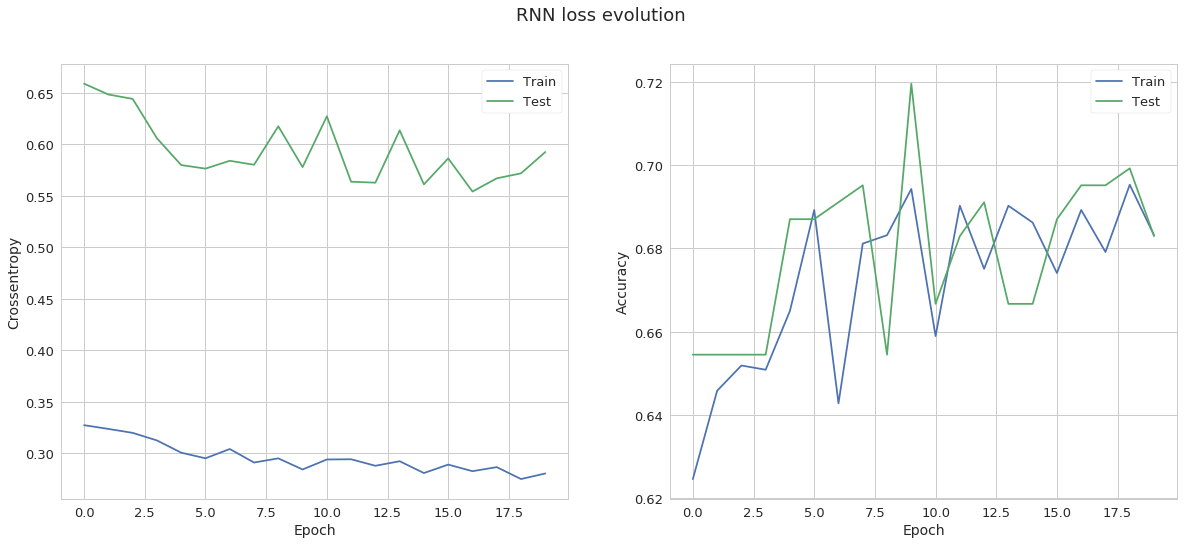

In [38]:
plt.figure(figsize=(20, 8))
plt.suptitle("RNN loss evolution", fontsize=18)

plt.subplot(121)
plt.plot(hist.history["loss"], label="Train")
plt.plot(hist.history["val_loss"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Crossentropy", fontsize=14)

plt.subplot(122)
plt.plot(hist.history["acc"], label="Train")
plt.plot(hist.history["val_acc"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14);

## Evaluation RNN

Do a prediction

In [39]:
preds_train = model.predict(X_train, verbose=0)
preds_test = model.predict(X_test, verbose=0)

preds_train = (preds_train > 0.5).astype(np.int)
preds_test = (preds_test > 0.5).astype(np.int)

Accuracy

In [40]:
print("Train accuracy:\t", np.round(metrics.accuracy_score(y_train, preds_train), 3))
print("Test accuracy:\t", np.round(metrics.accuracy_score(y_test, preds_test), 3))

Train accuracy:	 0.651
Test accuracy:	 0.683


Confusion matrix

In [41]:
cm_train = metrics.confusion_matrix(y_train, preds_train).astype(np.float32)
cm_train /= cm_train.sum(axis=1)[:, np.newaxis]

cm_test = metrics.confusion_matrix(y_test, preds_test).astype(np.float32)
cm_test /= cm_test.sum(axis=1)[:, np.newaxis]

In [42]:
class_labels = ["Regular", "Irony"]

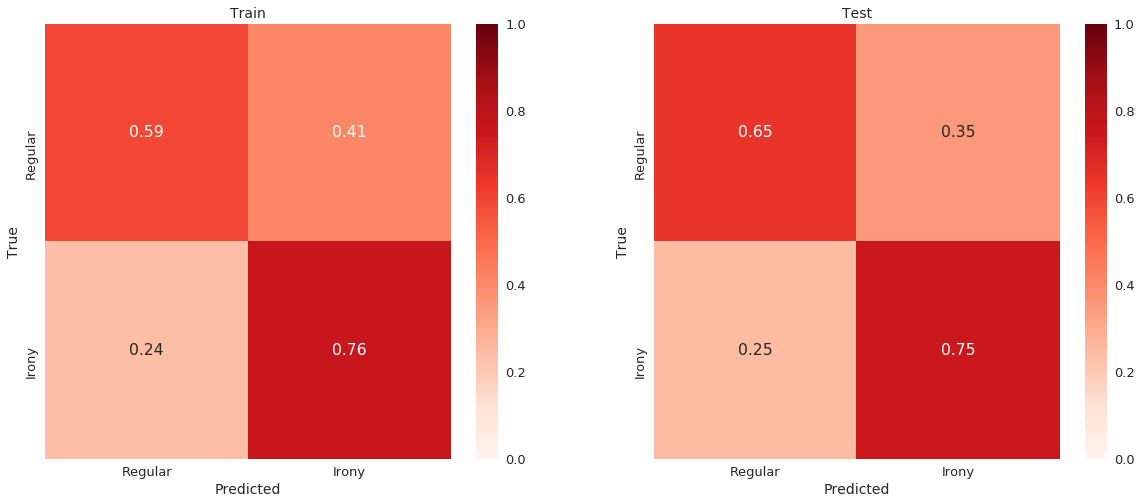

In [43]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
g = sns.heatmap(cm_train, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Train", fontsize=14)

plt.subplot(122)
g = sns.heatmap(cm_test, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test", fontsize=14);

In [44]:
print(metrics.classification_report(y_test, preds_test))

             precision    recall  f1-score   support

          0       0.83      0.65      0.73       161
          1       0.53      0.75      0.62        85

avg / total       0.73      0.68      0.69       246

